# <center> Unsupervised learning
## <center> Clustering k-Means
    
**This is mostly to demonstrate some applications of k-Means, for theory, study [topic 7](https://mlcourse.ai/notebooks/blob/master/jupyter_english/topic07_unsupervised/topic7_pca_clustering.ipynb?flush_cache=true) in our course**

## Clustering NBA players

Some <a href="http://www.databasebasketball.com/about/aboutstats.htm">info</a> on players' features.

In [2]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

nba = pd.read_csv("../data/nba_2013.csv")
nba.head()

,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,...,drb,trb,ast,stl,blk,tov,pf,pts,season,season_end
0,Quincy Acy,SF,23,TOT,63,0,847,66,141,0.468,...,144,216,28,23,26,30,122,171,2013-2014,2013
1,Steven Adams,C,20,OKC,81,20,1197,93,185,0.503,...,190,332,43,40,57,71,203,265,2013-2014,2013
2,Jeff Adrien,PF,27,TOT,53,12,961,143,275,0.520,...,204,306,38,24,36,39,108,362,2013-2014,2013
3,Arron Afflalo,SG,28,ORL,73,73,2552,464,1011,0.459,...,230,262,248,35,3,146,136,1330,2013-2014,2013
4,Alexis Ajinca,C,25,NOP,56,30,951,136,249,0.546,...,183,277,40,23,46,63,187,328,2013-2014,2013


/Users/esmaeilpourjavad/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


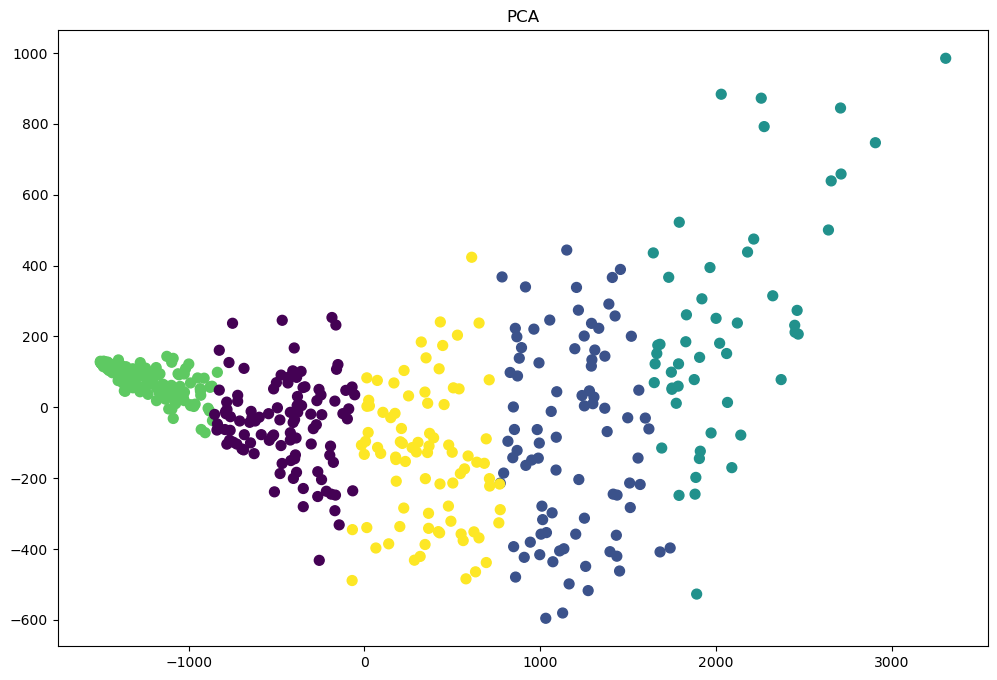

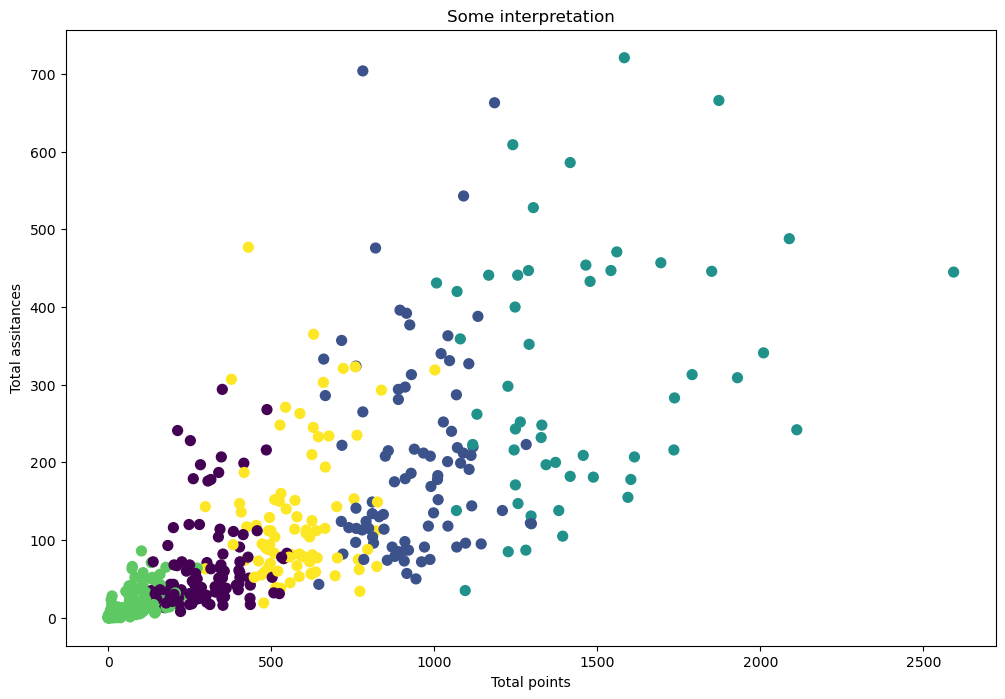

In [3]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

kmeans = KMeans(n_clusters=5, random_state=1)
numeric_cols = nba._get_numeric_data().dropna(axis=1)
kmeans.fit(numeric_cols)


# Visualizing using PCA
pca = PCA(n_components=2)
res = pca.fit_transform(numeric_cols)
plt.figure(figsize=(12,8))
plt.scatter(res[:,0], res[:,1], c=kmeans.labels_, s=50, cmap='viridis')
plt.title('PCA')

# Visualizing using 2 features: Total points vs. Total assists
plt.figure(figsize=(12,8))
plt.scatter(nba['pts'], nba['ast'], 
            c=kmeans.labels_, s=50, cmap='viridis')
plt.xlabel('Total points')
plt.ylabel('Total assitances')
plt.title('Some interpretation');

## Compressing images with k-Means 
*not a popular technique*

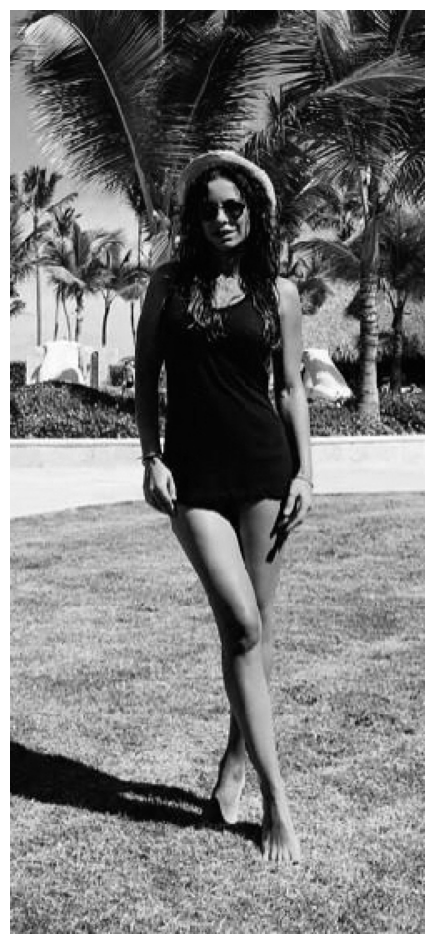

In [12]:
import matplotlib.image as mpimg

img = mpimg.imread('../figures/woman.jpg')[..., 1]
plt.figure(figsize = (20, 12))
plt.axis('off')
plt.imshow(img, cmap='gray');

/Users/esmaeilpourjavad/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


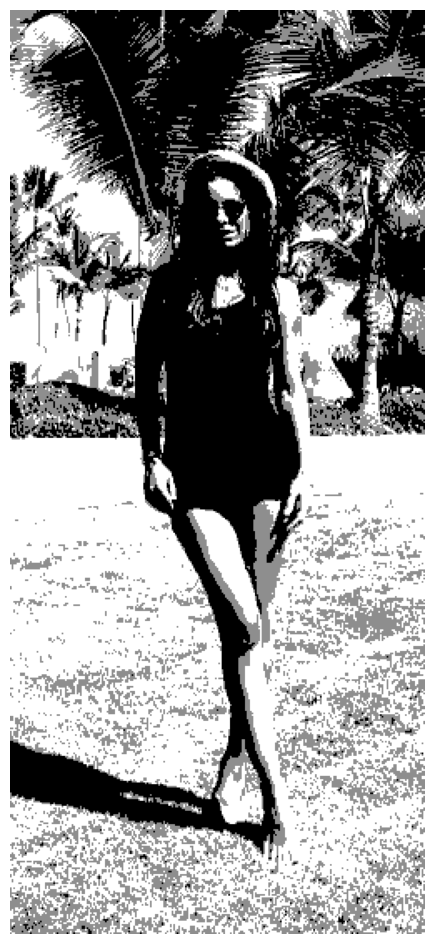

In [13]:
from scipy.stats import randint
from sklearn.cluster import MiniBatchKMeans

X = img.reshape((-1, 1))
k_means = MiniBatchKMeans(n_clusters=3)
k_means.fit(X) 
values = k_means.cluster_centers_
labels = k_means.labels_
img_compressed = values[labels].reshape(img.shape)
plt.figure(figsize = (20, 12))
plt.axis('off')
plt.imshow(img_compressed, cmap = 'gray');

# Finding latent topics in texts

**We'll apply k-Means to cluster texts from 4 categories.**

In [14]:
from time import time

from sklearn import metrics
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.preprocessing import Normalizer

categories = [
    'alt.atheism',
    'talk.religion.misc',
    'comp.graphics',
    'sci.space']

print("Loading 20 newsgroups dataset for categories:")
print(categories)

dataset = fetch_20newsgroups(subset='all', categories=categories,
                             shuffle=True, random_state=42)

print("%d documents" % len(dataset.data))
print("%d categories" % len(dataset.target_names))

labels = dataset.target
true_k = np.unique(labels).shape[0]

Loading 20 newsgroups dataset for categories:
['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
3387 documents
4 categories


**Build Tf-Idf features for texts**

In [15]:
print("Extracting features from the training dataset using a sparse vectorizer")
vectorizer = TfidfVectorizer(max_df=0.5, max_features=1000,
                             min_df=2, stop_words='english')

X = vectorizer.fit_transform(dataset.data)
print("n_samples: %d, n_features: %d" % X.shape)

Extracting features from the training dataset using a sparse vectorizer
n_samples: 3387, n_features: 1000


**Apply k-Means to the vectors that we've got. Also, calculate clustering metrics.**

In [16]:
km = KMeans(n_clusters=true_k, init='k-means++', 
            max_iter=100, n_init=1)

print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(X)

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, km.labels_, sample_size=1000))

order_centroids = km.cluster_centers_.argsort()[:, ::-1]

Clustering sparse data with KMeans(max_iter=100, n_clusters=4, n_init=1)
Homogeneity: 0.344
Completeness: 0.452
V-measure: 0.390
Adjusted Rand-Index: 0.316
Silhouette Coefficient: 0.015


**Output words that are close to cluster centers**

In [19]:
terms = vectorizer.get_feature_names_out()
for i in range(true_k):
    print("Cluster %d:" % (i + 1), end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

Cluster 1: access sgi digex keith caltech livesey pat com jon wpd
Cluster 2: henry toronto alaska zoo spencer nsmca zoology aurora space high
Cluster 3: space com university graphics posting host nntp nasa thanks like
Cluster 4: god com people sandvik jesus don christian article say think


## Clustering handwritten digits

In [20]:
from sklearn.datasets import load_digits

digits = load_digits()

X, y = digits.data, digits.target

In [21]:
kmeans = KMeans(n_clusters=10)
kmeans.fit(X)

/Users/esmaeilpourjavad/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=10)

In [22]:
from sklearn.metrics import adjusted_rand_score

adjusted_rand_score(y, kmeans.predict(X))

0.6551076438783415

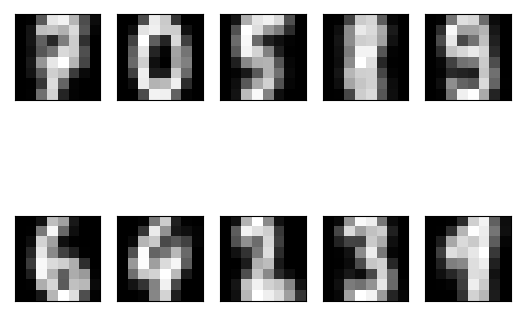

In [23]:
_, axes = plt.subplots(2, 5)
for ax, center in zip(axes.ravel(), kmeans.cluster_centers_):
    ax.matshow(center.reshape(8, 8), cmap=plt.cm.gray)
    ax.set_xticks(())
    ax.set_yticks(())